In [1]:
import numpy as np
import pickle
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def pickle_out(filename, object_to_dump):
    with open(filename, 'wb') as pickleFile:
        pickle.dump(object_to_dump, pickleFile)
        pickleFile.close()

def pickle_in(filename):
    with open(filename, 'rb') as pickleFile:
        return pickle.load(pickleFile)


def simplify_education(data):
    data = data[:, 1:]
    data[:, 3] = data[:, 3] + data[:, 2]
    data = data[:, 3:]
    return data

def prepare_with_zeros(data, adj_list, max_neighbors, attribute_idx_to_adj_index):
    x = np.zeros((data.shape[0], max_neighbors*data.shape[1]))
    y_education = np.zeros((data.shape[0],1))
    y_unemployment = np.zeros((data.shape[0], 1))

    for i, vals in adj_list.items():
        if i not in attribute_idx_to_adj_index:
            continue
        i = attribute_idx_to_adj_index[i]
        y_education[i] = data[i][0]
        y_unemployment[i] = data[i][2]

        idx = 0
        for j in vals:
            if j not in attribute_idx_to_adj_index:
                continue
            j = attribute_idx_to_adj_index[j]
            x[i][idx] = data[j][0]
            x[i][idx+1] = data[j][1]
            x[i][idx+2] = data[j][2]
            idx += 3

    return x, y_education, y_unemployment

def prepare_stats(data, adj_list, attribute_idx_to_adj_index):
    x = np.zeros((data.shape[0], 13))
    y_education = np.zeros((data.shape[0], 1))
    y_unemployment = np.zeros((data.shape[0], 1))

    for i, vals in adj_list.items():
        if i not in attribute_idx_to_adj_index:
            continue
        i = attribute_idx_to_adj_index[i]
        y_education[i] = data[i][0]
        y_unemployment[i] = data[i][2]

        x[i][12] = len(vals)    #record the number of neighbors
        features = [[], [], []]
        for j in vals:
            if j not in attribute_idx_to_adj_index:
                continue
            j = attribute_idx_to_adj_index[j]
            for idx in range(3): #there are 3 features
                features[idx].append(data[j][idx])

        curr = 0
        for idx in range(3):
            x[i][curr] = min(features[idx])
            x[i][curr+1] = max(features[idx])
            x[i][curr + 2] = np.mean(features[idx])
            x[i][curr + 3] = np.std(features[idx])
            curr += 4

    return x, y_education, y_unemployment

def do_regression(data_1990, data_2000, adj_list, attribute_idx_to_adj_index_1990, attribute_idx_to_adj_index_2000,
                  num_folds=5, seed=42):
    x_1990, y_education_1990, y_unemployment_1990 = prepare_stats(data_1990, adj_list,
                                                                  attribute_idx_to_adj_index_1990)
    x_2000, y_education_2000, y_unemployment_2000 = prepare_stats(data_2000, adj_list,
                                                                  attribute_idx_to_adj_index_2000)
    # This does z-score normalization of data
    x_1990 = (x_1990 - np.mean(x_1990, axis=0)) / np.std(x_1990, axis=0)
    x_2000 = (x_2000 - np.mean(x_2000, axis=0)) / np.std(x_2000, axis=0)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    education_1990_mse = []
    education_2000_mse = []
    education_2000_prime_mse = []

    unemployment_1990_mse = []
    unemployment_2000_mse = []
    unemployment_2000_prime_mse = []

    for train_idx, test_idx in kf.split(x_1990, y_education_1990):
        x_train_1990, y_train_1990_education, y_train_1990_unemployment = x_1990[train_idx], y_education_1990[
            train_idx], y_unemployment_1990[train_idx]
        x_test_1990, y_test_1990_education, y_test_1990_unemployment = x_1990[test_idx], y_education_1990[test_idx], \
                                                                       y_unemployment_1990[test_idx]

        x_train_2000, y_train_2000_education, y_train_2000_unemployment = x_2000[train_idx], y_education_2000[
            train_idx], y_unemployment_2000[train_idx]
        x_test_2000, y_test_2000_education, y_test_2000_unemployment = x_2000[test_idx], y_education_2000[test_idx], \
                                                                       y_unemployment_2000[test_idx]

        model_education = LinearRegression(normalize=False, n_jobs=-1).fit(x_train_1990, y_train_1990_education)
        y_pred_1990_education = model_education.predict(x_test_1990)
        y_pred_2000_education = model_education.predict(x_test_2000)

        model_education_2000 = LinearRegression(normalize=False, n_jobs=-1).fit(x_train_2000,
                                                                                y_train_2000_education)
        y_pred_2000_education_prime = model_education_2000.predict(x_test_2000)

        model_unemployment = LinearRegression(normalize=False, n_jobs=-1).fit(x_train_1990,
                                                                              y_train_1990_unemployment)
        y_pred_1990_unemployment = model_unemployment.predict(x_test_1990)
        y_pred_2000_unemployment = model_unemployment.predict(x_test_2000)

        model_unemployment_2000 = LinearRegression(normalize=False, n_jobs=-1).fit(x_train_2000,
                                                                                   y_train_2000_unemployment)
        y_pred_2000_unemployment_prime = model_unemployment_2000.predict(x_test_2000)

        education_1990_mse.append(mean_squared_error(y_test_1990_education, y_pred_1990_education))
        education_2000_mse.append(mean_squared_error(y_test_2000_education, y_pred_2000_education))
        education_2000_prime_mse.append(mean_squared_error(y_test_2000_education, y_pred_2000_education_prime))

        unemployment_1990_mse.append(mean_squared_error(y_test_1990_unemployment, y_pred_1990_unemployment))
        unemployment_2000_mse.append(mean_squared_error(y_test_2000_unemployment, y_pred_2000_unemployment))
        unemployment_2000_prime_mse.append(
            mean_squared_error(y_test_2000_unemployment, y_pred_2000_unemployment_prime))

    print('Education 1990 predicted using 1990 model:')
    print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(
        np.mean(education_1990_mse),
        np.median(education_1990_mse),
        np.std(education_1990_mse), np.min(education_1990_mse),
        np.max(education_1990_mse)))
    print()

    print('Education 2000 predicted using 1990 model:')
    print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(
        np.mean(education_2000_mse),
        np.median(
            education_2000_mse),
        np.std(education_2000_mse),
        np.min(education_2000_mse),
        np.max(education_2000_mse)))
    print()

    print('Education 2000 predicted using 2000 model:')
    print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(
        np.mean(education_2000_prime_mse),
        np.median(
            education_2000_prime_mse),
        np.std(education_2000_prime_mse),
        np.min(education_2000_prime_mse),
        np.max(education_2000_prime_mse)))
    print('******************************')

    print('Unemployment 1990 predicted using 1990 model:')
    print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(
        np.mean(unemployment_1990_mse),
        np.median(
            unemployment_1990_mse),
        np.std(unemployment_1990_mse),
        np.min(unemployment_1990_mse),
        np.max(unemployment_1990_mse)))
    print()

    print('Unemployment 2000 predicted using 1990 model:')
    print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(
        np.mean(unemployment_2000_mse),
        np.median(
            unemployment_2000_mse),
        np.std(unemployment_2000_mse),
        np.min(unemployment_2000_mse),
        np.max(unemployment_2000_mse)))
    print()

    print('Unemployment 2000 predicted using 2000 model:')
    print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(
        np.mean(unemployment_2000_prime_mse),
        np.median(
            unemployment_2000_prime_mse),
        np.std(unemployment_2000_prime_mse),
        np.min(unemployment_2000_prime_mse),
        np.max(unemployment_2000_prime_mse)))
    print('******************************')


def plot_weights(data_1990, data_2000, adj_list, attribute_idx_to_adj_index_1990, attribute_idx_to_adj_index_2000,
                  num_folds=2, seed=42):
    x_1990, y_education_1990, y_unemployment_1990 = prepare_stats(data_1990, adj_list,
                                                                  attribute_idx_to_adj_index_1990)
    x_2000, y_education_2000, y_unemployment_2000 = prepare_stats(data_2000, adj_list,
                                                                  attribute_idx_to_adj_index_2000)
    # This does z-score normalization of data
    x_1990 = (x_1990 - np.mean(x_1990, axis=0)) / np.std(x_1990, axis=0)
    x_2000 = (x_2000 - np.mean(x_2000, axis=0)) / np.std(x_2000, axis=0)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    fig, axes = plt.subplots(2, 2, figsize=(7, 7))

    for train_idx, test_idx in kf.split(x_1990, y_education_1990):
        x_train_1990, y_train_1990_education, y_train_1990_unemployment = x_1990[train_idx], y_education_1990[
            train_idx], y_unemployment_1990[train_idx]

        x_train_2000, y_train_2000_education, y_train_2000_unemployment = x_2000[train_idx], y_education_2000[
            train_idx], y_unemployment_2000[train_idx]


        model_education = LinearRegression(normalize=False, n_jobs=-1).fit(x_train_1990, y_train_1990_education)
        model_education_2000 = LinearRegression(normalize=False, n_jobs=-1).fit(x_train_2000,
                                                                                y_train_2000_education)

        model_unemployment = LinearRegression(normalize=False, n_jobs=-1).fit(x_train_1990, y_train_1990_unemployment)

        model_unemployment_2000 = LinearRegression(normalize=False, n_jobs=-1).fit(x_train_2000,
                                                                                   y_train_2000_unemployment)


        m1 = model_education.coef_[0]
        m2 = model_education_2000.coef_[0]
        education_min, education_max = min(min(m1),min(m2)), max(max(m1), max(m2))

        m3 = model_unemployment.coef_[0]
        m4 = model_unemployment_2000.coef_[0]
        unemployment_min, unemployment_max = min(min(m3), min(m4)), max(max(m3), max(m4))


        axes[0, 0].matshow(np.expand_dims(m1, axis=0), cmap='RdBu', vmin=education_min, vmax=education_max)
        axes[0, 0].set_yticks([], [])
        axes[0, 0].set_xticks(np.arange(0, 13))
        axes[0, 0].set_title('Education 1990 Coefficients', pad=30, fontweight='bold')

        im = axes[1, 0].matshow(np.expand_dims(m2, axis=0), cmap='RdBu', vmin=education_min, vmax=education_max)
        plt.colorbar(im, ax=axes[1, 0], orientation='horizontal')
        axes[1, 0].set_yticks([], [])
        axes[1, 0].set_xticks(np.arange(0, 13))
        axes[1, 0].set_title('Education 2000 Coefficients', pad=30, fontweight='bold')

        axes[0, 1].matshow(np.expand_dims(m3, axis=0), cmap='RdBu', vmin=unemployment_min, vmax=unemployment_max)
        axes[0, 1].set_yticks([], [])
        axes[0, 1].set_xticks(np.arange(0, 13))
        axes[0, 1].set_title('Unemployment 1990 Coefficients', pad=30, fontweight='bold')

        im = axes[1, 1].matshow(np.expand_dims(m4, axis=0), cmap='RdBu', vmin=unemployment_min, vmax=unemployment_max)
        plt.colorbar(im, ax=axes[1, 1], orientation='horizontal')
        axes[1, 1].set_yticks([], [])
        axes[1, 1].set_xticks(np.arange(0, 13))
        axes[1, 1].set_title('Unemployment 2000 Coefficients', pad=30, fontweight='bold')

        break

    plt.tight_layout()
    plt.show()

    print('0 = min education',)
    print('1 = max education', )
    print('2 = mean education', )
    print('3 = std education', )
    print('4 = min population', )
    print('5 = max population', )
    print('6 = mean population', )
    print('7 = std population', )
    print('8 = min unemployment', )
    print('9 = max unemployment', )
    print('10 = mean unemployment', )
    print('11 = std unemployment', )
    print('12 = number of neighbors')

    
    

Education 1990 predicted using 1990 model:
Mean Squared Error: mean = 59.21244666725632, median = 55.79473512112337, std = 5.0854556449833845, min = 54.52722454318175, max = 66.74810546388908

Education 2000 predicted using 1990 model:
Mean Squared Error: mean = 115.04843116814163, median = 114.07532194246095, std = 5.159557345714118, min = 108.65119825916014, max = 122.85357158760958

Education 2000 predicted using 2000 model:
Mean Squared Error: mean = 60.28216740609899, median = 58.409939820974564, std = 4.657863141494461, min = 54.66462164478816, max = 66.66394713970153
******************************
Unemployment 1990 predicted using 1990 model:
Mean Squared Error: mean = 21.54868997149039, median = 20.971740467826226, std = 1.493130216984411, min = 20.17305335178057, max = 24.16632811371358

Unemployment 2000 predicted using 1990 model:
Mean Squared Error: mean = 24.411994233385162, median = 24.355741579677662, std = 0.7327883716211818, min = 23.272984669951047, max = 25.308445405

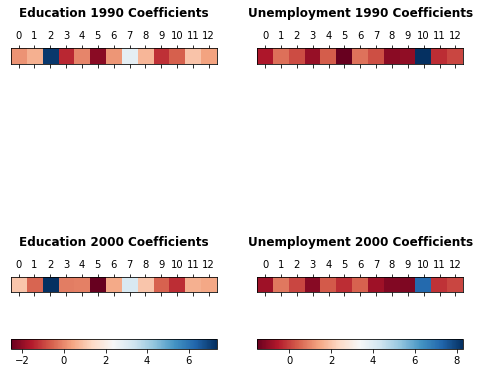

0 = min education
1 = max education
2 = mean education
3 = std education
4 = min population
5 = max population
6 = mean population
7 = std population
8 = min unemployment
9 = max unemployment
10 = mean unemployment
11 = std unemployment
12 = number of neighbors


In [3]:
    data_1990 = pickle_in('data/processed_data/clean_regression_1990')
    attribute_idx_to_adj_index_1990 = {j:i for i,j in enumerate(data_1990[:, 0])}
    data_1990 = simplify_education(data_1990)
    data_2000 = pickle_in('data/processed_data/clean_regression_2000')
    attribute_idx_to_adj_index_2000 = {j:i for i,j in enumerate(data_2000[:, 0])}
    data_2000 = simplify_education(data_2000)

    n = data_1990.shape[0]

    adj_list = pickle_in('data/processed_data/adj_list')

    max_neighbors = max([len(vals) for vals in adj_list.values()])

    do_regression(data_1990, data_2000, adj_list, attribute_idx_to_adj_index_1990, attribute_idx_to_adj_index_2000)
    plot_weights(data_1990, data_2000, adj_list, attribute_idx_to_adj_index_1990, attribute_idx_to_adj_index_2000)